In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 12.0, 8.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot

import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Concatenate, Dense, Activation, Reshape, Conv1D , Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization, Embedding, LSTM

Using TensorFlow backend.


CPU times: user 2.92 s, sys: 571 ms, total: 3.49 s
Wall time: 4.18 s


In [2]:
classes = 7
group = 5
training_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

def reader_pmtall(path):
    extra = np.arange(4096, 4480)
    
    tree = uproot.open(path)["tree"]
    pmtall = tree.array("PMTALL")
    pmtall = np.delete(pmtall, extra, axis=1)
    return pmtall

def reader(path,branch,number):
    tree = uproot.open(path)["tree"]
    column = tree.array(branch)
    column = column[:,number]
    return column

def reader_lone(path,branch):
    tree = uproot.open(path)["tree"]
    column = tree.array(branch)
    return column

def pmtall_pedestal(path):
    pedestal = reader(path,"Pedestal",0)
    pmtall = reader_pmtall(path)
    for i in range(len(pedestal)):
        pmtall[i] = -(pmtall[i]-pedestal[i])
    
    return pmtall

def label(q,k):
    x = np.zeros(len(q))
    for i in range(len(q)):
        x[i] = k
    return x

def sep(q,k,z):
    y = label(q,k)
    x1, x2 ,x3 = np.split(q,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    y1, y2 ,y3 = np.split(y,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    if z == 0:
        return x1, y1
    if z == 1:
        return x2, y2
    if z == 2:
        return x3, y3
    
def comb(one,two,three,four,five,portion):
    one1,one2 = sep(one,0,portion)
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,2,portion)
    four1,four2 = sep(four,3,portion)
    five1,five2 = sep(five,4,portion)
#     six1,six2 = sep(six,5,portion)
#     seven1,seven2 = sep(seven,6,portion)
    
    z = np.concatenate((one1,two1,three1,four1,five1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2),axis=0)
    return z, y

def comb5(one,two,three,four,five,portion):
    one1,one2 = sep(one,0,portion)    
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,2,portion)
    four1,four2 = sep(four,3,portion)
    five1,five2 = sep(five,4,portion)
    
    z = np.concatenate((one1,two1,three1,four1,five1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2),axis=0)
    return z, y

def parameters(path):
    ratio4us = reader_lone(path,"Ratio4us")
    energy = reader(path,"Energy",1)
#     dataquality0 = reader(path,"DataQuality",0)
#     dataquality1 = reader(path,"DataQuality",1)
#     dataquality2 = reader(path,"DataQuality",2)
#     dataquality3 = reader(path,"DataQuality",3)
    psdpara1 = reader(path,"PSDPara",1)
    psdpara7 = reader(path,"PSDPara",7)
    psdpara13 = reader(path,"PSDPara",13)
    psdpara22 = reader(path,"PSDPara",22)
#     triggercounter33 = reader(path,"TriggerCounter",33)
#     triggercounter36 = reader(path,"TriggerCounter",36)
    crystaln = reader(path,"CrystalN",0)
    position = reader(path,"Position_wm",1)
    ratio = reader_lone(path,"Ratio")
    timingdiff = reader_lone(path,"TimingDiff")
    x = np.stack((ratio4us,energy,psdpara1,psdpara7,psdpara13,psdpara22,crystaln,position,ratio,timingdiff),axis=-1)
    return x

def generator(x):
    while 1:
        alpha = pmtall_pedestal("Alpha.root")
#         bad1 = pmtall_pedestal("BAD_DATA_QUALITY_1.root")
#         bad2 = pmtall_pedestal("BAD_DATA_QUALITY_2.root")
        piled = pmtall_pedestal("Piled_2.root")
        ls = pmtall_pedestal("LS.root")
        lsbeta = pmtall_pedestal("lsbeta.root")
        ref = pmtall_pedestal("RefPulse009.root")
        
        z1, z2 = comb(piled,ref,alpha,ls,lsbeta,x)
        s = np.random.permutation(np.arange(len(z2)))
        z1 = z1[s]
        z2 = z2[s]

        para_piled = parameters("Piled_2.root")
        para_ref = parameters("RefPulse009.root")
        para_alpha = parameters("Alpha.root")
        para_ls = parameters("LS.root")
        para_lsbeta = parameters("lsbeta.root")
        
        z3, z4 = comb5(para_piled,para_ref,para_alpha,para_ls,para_lsbeta,x)        
        z3 = z3[s] 
        z4 = z4[s]

        gasf = GASF(image_size=128, overlapping=False, scale='-1')
        
        for i in range(len(z2)):
            d1 = np.expand_dims(z1[i],axis=0)
            p = gasf.transform(d1)
            q = keras.utils.to_categorical(z2[i],classes)
            r = normalize(d1,norm="l1")
            s = np.expand_dims(z3[i],axis=0)
            yield [r,p,s],q

test = generator(1)
print(next(test)[0][0])
print(next(test)[0][0].shape)
print(next(test)[0][1].shape)
print(next(test)[0][2].shape)
print(next(test)[1].shape)

[[  1.47245382e-05  -2.50169669e-05  -1.17206400e-06 ...,  -2.32860380e-08
    1.46702041e-06   4.13715270e-06]]
(1, 4096)
(1, 128, 128)
(1, 10)
(1, 7)


In [3]:
def multiple_inputs():
    feeder_1d = Input(shape=(4096,))
    model1 = Reshape((4096,1),input_shape=(4096,))(feeder_1d)
    model1 = Conv1D(64, kernel_size=16, strides=8,padding='same')(model1)
    model1 = MaxPooling1D(pool_size=2)(model1)
    model1 = Activation("relu")(model1)
    model1 = Conv1D(32, kernel_size=16, strides=8,padding='same')(model1)
    model1 = MaxPooling1D(pool_size=2)(model1)
    model1 = Activation("relu")(model1)
    model1 = Flatten()(model1)
    model1 = Dense(128,activation="relu")(model1)
    model1 = Dropout(0.2)(model1)
    model1 = Dense(64,activation="relu")(model1)
    model1 = Dropout(0.2)(model1)
    waveform_1d_out = Dense(7,activation="sigmoid")(model1)
    
    feeder_2d = Input(shape=(128,128))
    model2 = Reshape((128,128,1),input_shape=(128,128))(feeder_2d)
    model2 = Conv2D(64, kernel_size=(8,8),strides=4,padding='same')(model2)
    model2 = MaxPooling2D(pool_size=2)(model2)
    model2 = Activation("relu")(model2)
    model2 = Conv2D(32, kernel_size=(16,16),strides=4,padding='same')(model2)
    model2 = MaxPooling2D(pool_size=2)(model2)
    model2 = Activation("relu")(model2)
    model2 = Dropout(0.2)(model2)
    model2 = Flatten()(model2)
#     model2 = Dense(256,activation="relu")(model2)
#     model2 = Dropout(0.3)(model2)
    model2 = Dense(128,activation="relu")(model2)
    model2 = Dropout(0.3)(model2)
#     model2 = Dense(64,activation="relu")(model2)
#     model2 = Dropout(0.3)(model2)
    waveform_2d_out = Dense(7,activation="sigmoid")(model2)
    
    feeder_para = Input(shape=(10,))
    model3 = Dense(64,activation="relu")(feeder_para)
    model3 = Dropout(0.2)(model3)
    model3 = Dense(64,activation="relu")(model3)
    model3 = Dropout(0.2)(model3)
#     model3 = Dense(128,activation="relu")(model3)
#     model3 = Dropout(0.2)(model3)
    para_dense = Dense(7,activation="sigmoid")(model3)
    
    x = keras.layers.concatenate([waveform_1d_out, waveform_2d_out, para_dense])
    x = Dense(256,activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(256,activation="relu")(x)
    x = Dropout(0.2)(x)
    main_output = Dense(7, activation='softmax', name='main_output')(x)
    
    model = Model(inputs=[feeder_1d,feeder_2d,feeder_para],outputs=[main_output])
    model.summary()
    
    return model

mult = multiple_inputs()
mult.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 4096)          0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 4096, 1)       0           input_1[0][0]                    
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 128, 128)      0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 512, 64)       1088        reshape_1[0][0]                  
___________________________________________________________________________________________

Epoch 1/5
21430/21430 [==============================] - 720s - loss: 0.1230 - acc: 0.9435 - val_loss: 0.0647 - val_acc: 0.9771
Epoch 2/5
21430/21430 [==============================] - 659s - loss: 0.0657 - acc: 0.9738 - val_loss: 0.0387 - val_acc: 0.9864
Epoch 3/5
21430/21430 [==============================] - 695s - loss: 0.0479 - acc: 0.9833 - val_loss: 0.0328 - val_acc: 0.9907
Epoch 4/5
21430/21430 [==============================] - 723s - loss: 0.0452 - acc: 0.9855 - val_loss: 0.0316 - val_acc: 0.9906
Epoch 5/5
21430/21430 [==============================] - 698s - loss: 0.0431 - acc: 0.9866 - val_loss: 0.0243 - val_acc: 0.9942
dict_keys(['loss', 'val_acc', 'acc', 'val_loss'])


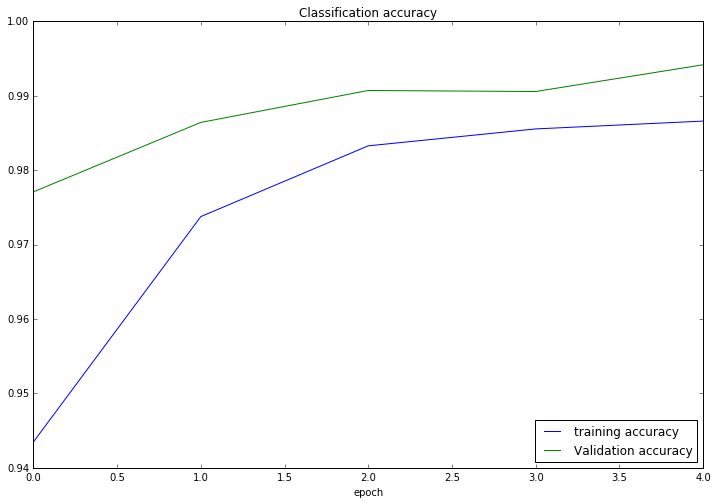

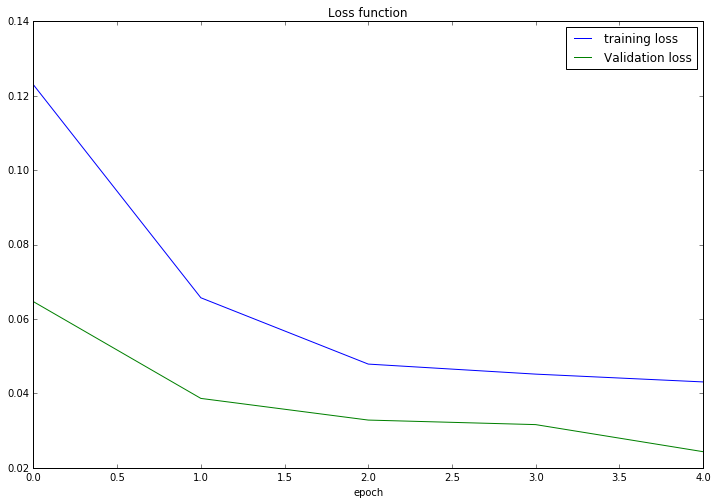

Classification accuracy = 0.994168144418
Test loss: 0.0251732986702
Test accuracy: 0.995054586466


In [4]:
train_gen = generator(0)
val_gen = generator(1)
test_gen = generator(2)

steps_t = 21430
steps_vt = 3062

history = mult.fit_generator(train_gen,steps_per_epoch=steps_t, epochs=5, verbose=1, validation_data=val_gen,validation_steps=steps_vt)
print(history.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
plt.plot(history.history['acc'],label="training accuracy")
plt.plot(history.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

print("Classification accuracy =",history.history['val_acc'][-1])

mult.save("GPU_CNN.h5")

score = mult.evaluate_generator(test_gen,steps=1531)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [5]:
mult.save("CNN_more_filter_longer_6000s_training.h5")